# # Physical Constraint Check: BC=0 when Fabs=0
# 
# This notebook recreates the "Physical Constraint Check" plot that demonstrates
# which MAC calculation methods violate the physical constraint that Black Carbon
# should equal zero when light absorption (Fabs) equals zero.
# 
# **Key Question**: Should BC = 0 when Fabs = 0?
# - Methods without intercepts: YES (passes through origin)
# - Method 3 with intercept: NO (predicts BC > 0 even when Fabs = 0)

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import pandas as pd
# Add path to import the matcher
sys.path.insert(0, '..')
# Import directly from the module file to avoid package init issues
from src.data.loaders.aethalometer_filter_matcher import AethalometerFilterMatcher
# Set publication-quality plotting parameters
plt.rcParams.update({
    'figure.figsize': [14, 10],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

In [4]:
# CONFIGURATION - UPDATE THESE FOR YOUR DATA
AETHALOMETER_PATH = "../FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl"
FILTER_DB_PATH = "../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl"
SITE_CODE = "ETAD"  # Update this to your site code

print("Loading data...")

Loading data...


In [5]:
def load_data_for_site(aethalometer_path, filter_db_path, site_code):
    """
    Load HIPS Fabs and FTIR EC data for a specific site
    
    Parameters:
    -----------
    aethalometer_path : str
        Path to aethalometer data pickle file
    filter_db_path : str
        Path to unified filter dataset pickle file
    site_code : str
        Site code (e.g., 'ETAD')
        
    Returns:
    --------
    pandas.DataFrame with 'EC_ftir' and 'HIPS_Fabs' columns
    """
    
    # Create matcher and load data
    matcher = AethalometerFilterMatcher(aethalometer_path, filter_db_path)
    
    # Match site data - we only need EC and HIPS Fabs
    matched_data = matcher.match_site_data(
        site_code,
        filter_parameters=['EC_ftir', 'HIPS_Fabs'],
        aethalometer_columns=[]  # Don't need aethalometer data for this analysis
    )
    
    # Filter to only samples with both measurements
    valid_mask = matched_data[['EC_ftir', 'HIPS_Fabs']].notna().all(axis=1)
    df_clean = matched_data.loc[valid_mask, ['datetime_local', 'match_date', 'EC_ftir', 'HIPS_Fabs']].copy()
    
    # Rename columns to match the notebook expectations
    df_clean = df_clean.rename(columns={
        'EC_ftir': 'ec_ftir',
        'HIPS_Fabs': 'fabs'
    })
    
    print(f"\n{'='*70}")
    print(f"DATA LOADED FOR SITE: {site_code}")
    print(f"{'='*70}")
    print(f"Total matched samples: {len(matched_data)}")
    print(f"Samples with both EC and HIPS Fabs: {len(df_clean)}")
    print(f"Date range: {df_clean['match_date'].min()} to {df_clean['match_date'].max()}")
    print(f"\nData summary:")
    print(df_clean[['ec_ftir', 'fabs']].describe())
    
    return df_clean

# Load the data
df = load_data_for_site(AETHALOMETER_PATH, FILTER_DB_PATH, SITE_CODE)

print("\nData loaded successfully!")
print(f"Columns available: {df.columns.tolist()}")
print(f"Number of samples: {len(df)}")

Loading complete filter dataset from ../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl...
Dataset loaded successfully!
   Total measurements: 44,493
   Unique filters: 1,603
   Sites: CHTS, ETAD, INDH, USPA
   Date range: 2013-06-28 to 2024-12-08
   Data sources: ChemSpec, FTIR, HIPS
✅ Filter database loaded from: ../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl
🔗 Matching aethalometer and filter data for ETAD...
✅ Aethalometer data loaded from: ../FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl
   Dataset shape: (1047, 320)
   Date range: 2022-04-13 09:00:00+03:00 to 2025-06-25 09:00:00+03:00
   No 'Site' column found - assuming single site data
📍 No 'Site' column - assuming all data is for ETAD
📂 Extracting ETAD filter measurements...
   ✅ EC_ftir: 190 measurements
      Date range: 2022-12-07 to 2024-09-21
   ✅ HIPS_Fabs: 190 measurements
      Date range: 2022-12-07 to 2024-09-21

✅ Combined filter dataset: (192, 3)
   Date range: 2022-12-07 to 2024-09-21
   Data complete

# ## Configuration and Data Loading
# 
# Update these parameters for your specific dataset and site.

# ## Calculate MAC Using All 4 Methods
# 
# We'll calculate the Mass Absorption Cross-section (MAC) using four different methods:
# 
# 1. **Method 1**: Mean of individual Fabs/EC ratios
# 2. **Method 2**: Ratio of mean Fabs to mean EC
# 3. **Method 3**: Standard linear regression (with intercept) - **Has intercept issue**
# 4. **Method 4**: Linear regression through origin (no intercept)

In [6]:
def calculate_all_mac_methods(df):
    """
    Calculate MAC values using all 4 methods
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Must contain 'ec_ftir' and 'fabs' columns
        
    Returns:
    --------
    dict : Dictionary containing MAC values, intercepts, and metadata for each method
    """
    
    ec_original = df['ec_ftir'].values
    fabs_original = df['fabs'].values
    
    print(f"\n{'='*80}")
    print(f"CALCULATING MAC VALUES FOR ALL METHODS")
    print(f"{'='*80}")
    print(f"Number of samples: {len(ec_original)}")
    print(f"EC range: {ec_original.min():.2f} - {ec_original.max():.2f} μg/m³")
    print(f"Fabs range: {fabs_original.min():.2f} - {fabs_original.max():.2f} Mm⁻¹")
    
    # Method 1: Mean of individual ratios
    individual_mac = df['fabs'] / df['ec_ftir']
    mac_method1 = individual_mac.mean()
    
    # Method 2: Ratio of means
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    # Method 3: Standard regression (WITH INTERCEPT)
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method3 = reg_standard.coef_[0]
    intercept_method3 = reg_standard.intercept_
    
    # Method 4: Origin regression (NO INTERCEPT)
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_original.reshape(-1, 1), fabs_original)
    mac_method4 = reg_origin.coef_[0]
    
    # Calculate BC equivalent lines for plotting
    fabs_range = np.linspace(0, fabs_original.max() * 1.2, 100)
    
    # Store all results
    results = {
        'ec_original': ec_original,
        'fabs_original': fabs_original,
        'fabs_range': fabs_range,
        'methods': {
            'Method 1: Mean of Ratios': {
                'mac': mac_method1,
                'intercept': 0,
                'color': '#e74c3c',
                'bc_line': fabs_range / mac_method1,
                'bc_at_zero_fabs': 0
            },
            'Method 2: Ratio of Means': {
                'mac': mac_method2,
                'intercept': 0,
                'color': '#27ae60',
                'bc_line': fabs_range / mac_method2,
                'bc_at_zero_fabs': 0
            },
            'Method 3: Standard Regression': {
                'mac': mac_method3,
                'intercept': intercept_method3,
                'color': '#3498db',
                'bc_line': np.maximum(fabs_range - intercept_method3, 0) / mac_method3,
                'bc_at_zero_fabs': -intercept_method3 / mac_method3
            },
            'Method 4: Origin Regression': {
                'mac': mac_method4,
                'intercept': 0,
                'color': '#9b59b6',
                'bc_line': fabs_range / mac_method4,
                'bc_at_zero_fabs': 0
            }
        }
    }
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"MAC VALUES SUMMARY")
    print(f"{'='*80}")
    
    for i, (method_name, data) in enumerate(results['methods'].items(), 1):
        print(f"\nMethod {i}: {method_name}")
        print(f"  MAC = {data['mac']:.3f} m²/g")
        print(f"  Intercept = {data['intercept']:.3f} Mm⁻¹")
        print(f"  BC when Fabs=0: {data['bc_at_zero_fabs']:.3f} μg/m³")
        
        if abs(data['bc_at_zero_fabs']) > 0.01:
            print(f"  ⚠️  VIOLATES physical constraint (BC ≠ 0 when Fabs = 0)")
        else:
            print(f"  ✅ SATISFIES physical constraint (BC = 0 when Fabs = 0)")
    
    return results

# Calculate MAC for all methods
results = calculate_all_mac_methods(df)


CALCULATING MAC VALUES FOR ALL METHODS
Number of samples: 175
EC range: 0.69 - 11.74 μg/m³
Fabs range: 28.09 - 85.85 Mm⁻¹

MAC VALUES SUMMARY

Method 1: Method 1: Mean of Ratios
  MAC = 11.008 m²/g
  Intercept = 0.000 Mm⁻¹
  BC when Fabs=0: 0.000 μg/m³
  ✅ SATISFIES physical constraint (BC = 0 when Fabs = 0)

Method 2: Method 2: Ratio of Means
  MAC = 9.606 m²/g
  Intercept = 0.000 Mm⁻¹
  BC when Fabs=0: 0.000 μg/m³
  ✅ SATISFIES physical constraint (BC = 0 when Fabs = 0)

Method 3: Method 3: Standard Regression
  MAC = 4.025 m²/g
  Intercept = 28.538 Mm⁻¹
  BC when Fabs=0: -7.090 μg/m³
  ⚠️  VIOLATES physical constraint (BC ≠ 0 when Fabs = 0)

Method 4: Method 4: Origin Regression
  MAC = 8.631 m²/g
  Intercept = 0.000 Mm⁻¹
  BC when Fabs=0: 0.000 μg/m³
  ✅ SATISFIES physical constraint (BC = 0 when Fabs = 0)


# ## Create the Physical Constraint Check Plot
# 
# This plot demonstrates which methods violate the physical expectation that
# BC should equal zero when light absorption (Fabs) equals zero.
# 
# **Key Features**:
# - Solid lines: Methods that satisfy the constraint (pass through origin)
# - Dashed lines: Methods with intercepts (violate the constraint)
# - Red shaded region: Where Method 3 predicts BC > 0 despite Fabs = 0

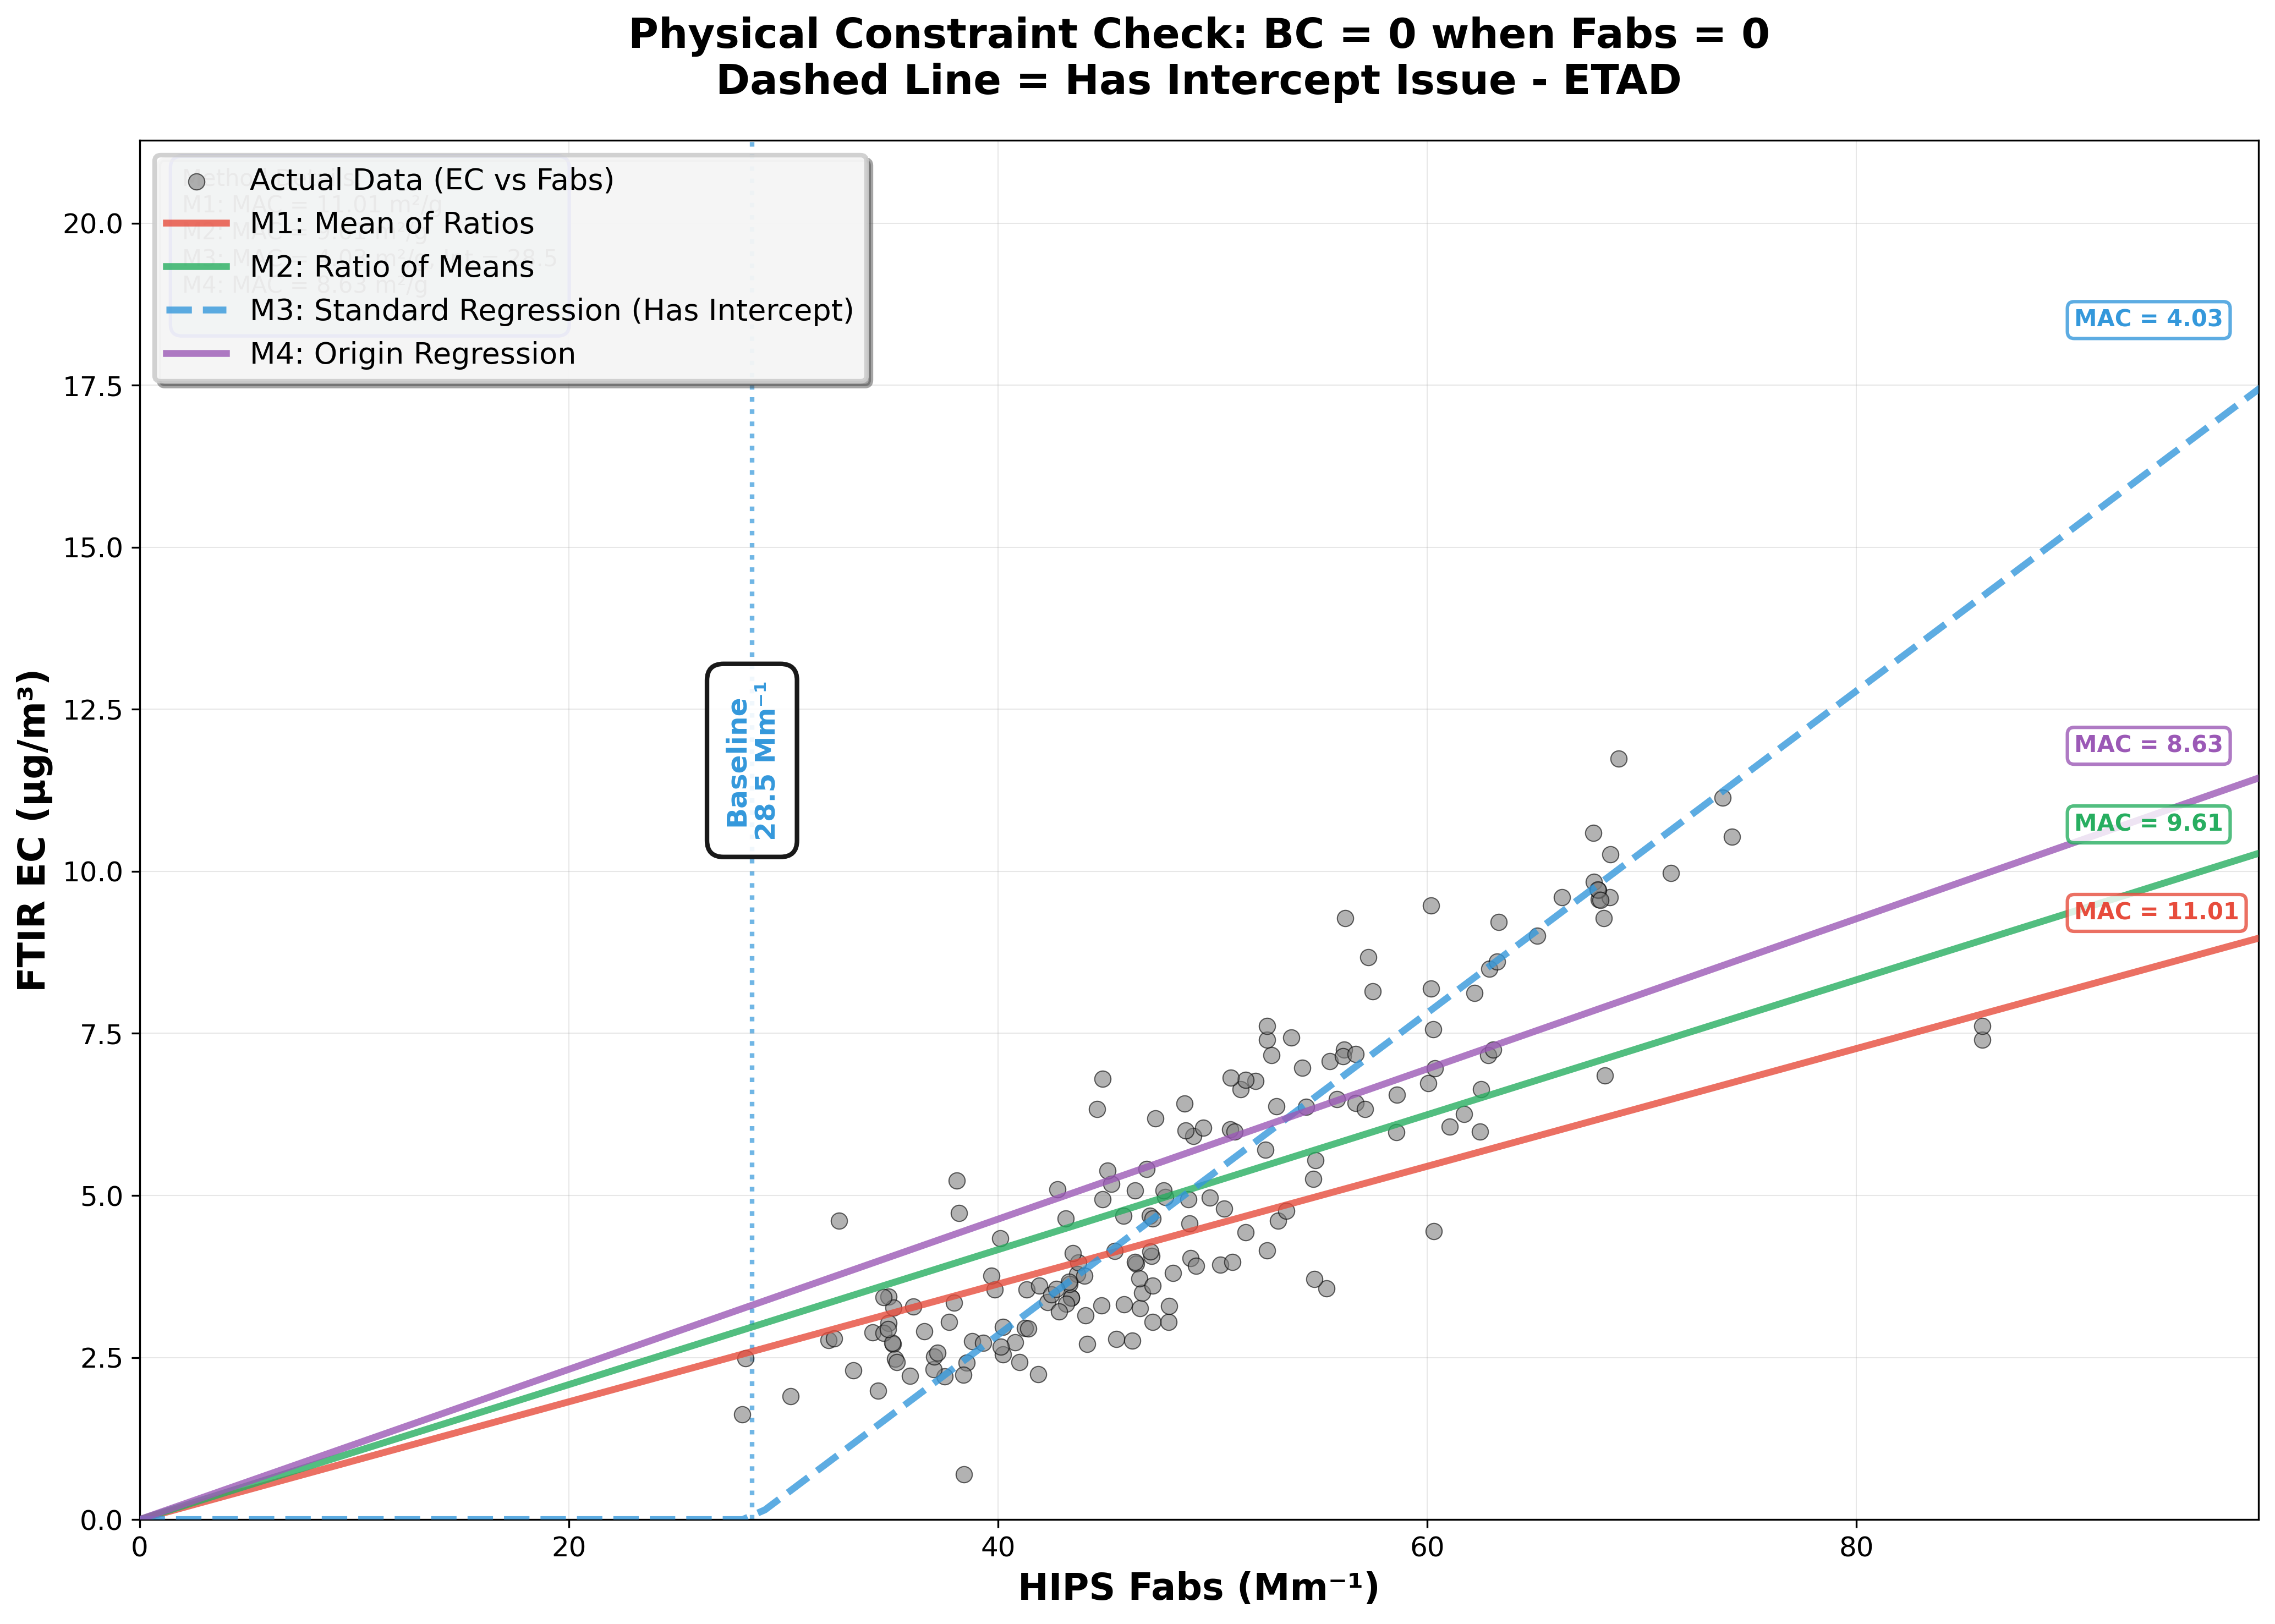

In [13]:
def plot_physical_constraint_check(results, site_code='ETAD'):
    """
    Create the physical constraint check plot
    
    Shows BC equivalent vs Fabs for all methods, highlighting which methods
    violate the constraint that BC should equal zero when Fabs equals zero.
    """
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Extract data
    ec_data = results['ec_original']
    fabs_data = results['fabs_original']
    fabs_range = results['fabs_range']
    
    # Plot actual data points
    ax.scatter(fabs_data, ec_data, alpha=0.6, s=50, color='gray', 
               label='Actual Data (EC vs Fabs)', zorder=2, edgecolors='black', linewidth=0.5)
    
    # Track which methods have intercepts for the legend
    has_intercept_shown = False
    
    # Plot BC equivalent lines for each method
    for i, (method_name, data) in enumerate(results['methods'].items(), 1):
        method_short = f"M{i}"
        
        if data['intercept'] != 0:
            # Method with intercept - show as DASHED line
            linestyle = '--'
            linewidth = 3
            alpha = 0.8
            
            ax.plot(fabs_range, data['bc_line'], 
                   color=data['color'], linewidth=linewidth, linestyle=linestyle,
                   alpha=alpha, label=f"{method_short}: {method_name.split(':')[1].strip()} (Has Intercept)",
                   zorder=3)
            
            # Highlight the intercept issue with vertical line
            ax.axvline(x=data['intercept'], color=data['color'], linestyle=':', 
                      alpha=0.7, linewidth=2, zorder=1)
            
            # Add annotation for the intercept
            ax.text(data['intercept'], max(ec_data) * 0.9, 
                   f"Baseline\n{data['intercept']:.1f} Mm⁻¹", 
                   ha='center', rotation=90, color=data['color'], 
                   fontweight='bold', fontsize=12,
                   bbox=dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.9, linewidth=2))
            
            # Mark that we've processed a method with intercept
            if not has_intercept_shown and data['intercept'] > 0:
                has_intercept_shown = True
                
        else:
            # Method without intercept - show as SOLID line
            linestyle = '-'
            linewidth = 3
            alpha = 0.8
            
            ax.plot(fabs_range, data['bc_line'], 
                   color=data['color'], linewidth=linewidth, linestyle=linestyle,
                   alpha=alpha, label=f"{method_short}: {method_name.split(':')[1].strip()}",
                   zorder=3)
    
    # Customize plot
    ax.set_xlabel('HIPS Fabs (Mm⁻¹)', fontweight='bold', fontsize=16)
    ax.set_ylabel('FTIR EC (μg/m³)', fontweight='bold', fontsize=16)
    ax.set_title(f'Physical Constraint Check: BC = 0 when Fabs = 0\n'
                f'Dashed Line = Has Intercept Issue - {site_code}', 
                fontweight='bold', fontsize=18, pad=20)
    
    # Find the maximum y-value from all BC lines to set proper limits
    max_bc_line = max([data['bc_line'][-1] for data in results['methods'].values()])
    
    # Set axis limits to show origin clearly and leave room for annotations
    ax.set_xlim(0, max(fabs_data) * 1.15)
    ax.set_ylim(0, max(max_bc_line * 1.15, max(ec_data) * 1.1))
    
    # Add MAC value annotations at the end of each line (after setting limits)
    for i, (method_name, data) in enumerate(results['methods'].items(), 1):
        # Position at the end of the line
        x_pos = max(fabs_data) * 1.05
        y_pos = data['bc_line'][-1]  # Get the y-value at the end of the line
        
        # Add text annotation with MAC value
        ax.text(x_pos, y_pos, f"MAC = {data['mac']:.2f}", 
               color=data['color'], fontweight='bold', fontsize=10,
               verticalalignment='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                        alpha=0.8, edgecolor=data['color'], linewidth=1.5))
    
    # Add legend
    legend = ax.legend(loc='upper left', frameon=True, fancybox=True, 
                      shadow=True, fontsize=13)
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_linewidth(2)
    
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add method details box
    method_details = "Method Details:\n"
    for i, (method_name, data) in enumerate(results['methods'].items(), 1):
        method_details += f"M{i}: MAC = {data['mac']:.2f} m²/g"
        if data['intercept'] != 0:
            method_details += f", Int = {data['intercept']:.1f}"
        method_details += "\n"
    
    ax.text(0.02, 0.98, method_details, transform=ax.transAxes, fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', 
                     alpha=0.9, edgecolor='blue', linewidth=1.5))
    
    plt.tight_layout()
    
    return fig

# Create the plot
fig = plot_physical_constraint_check(results, site_code=SITE_CODE)
plt.show()



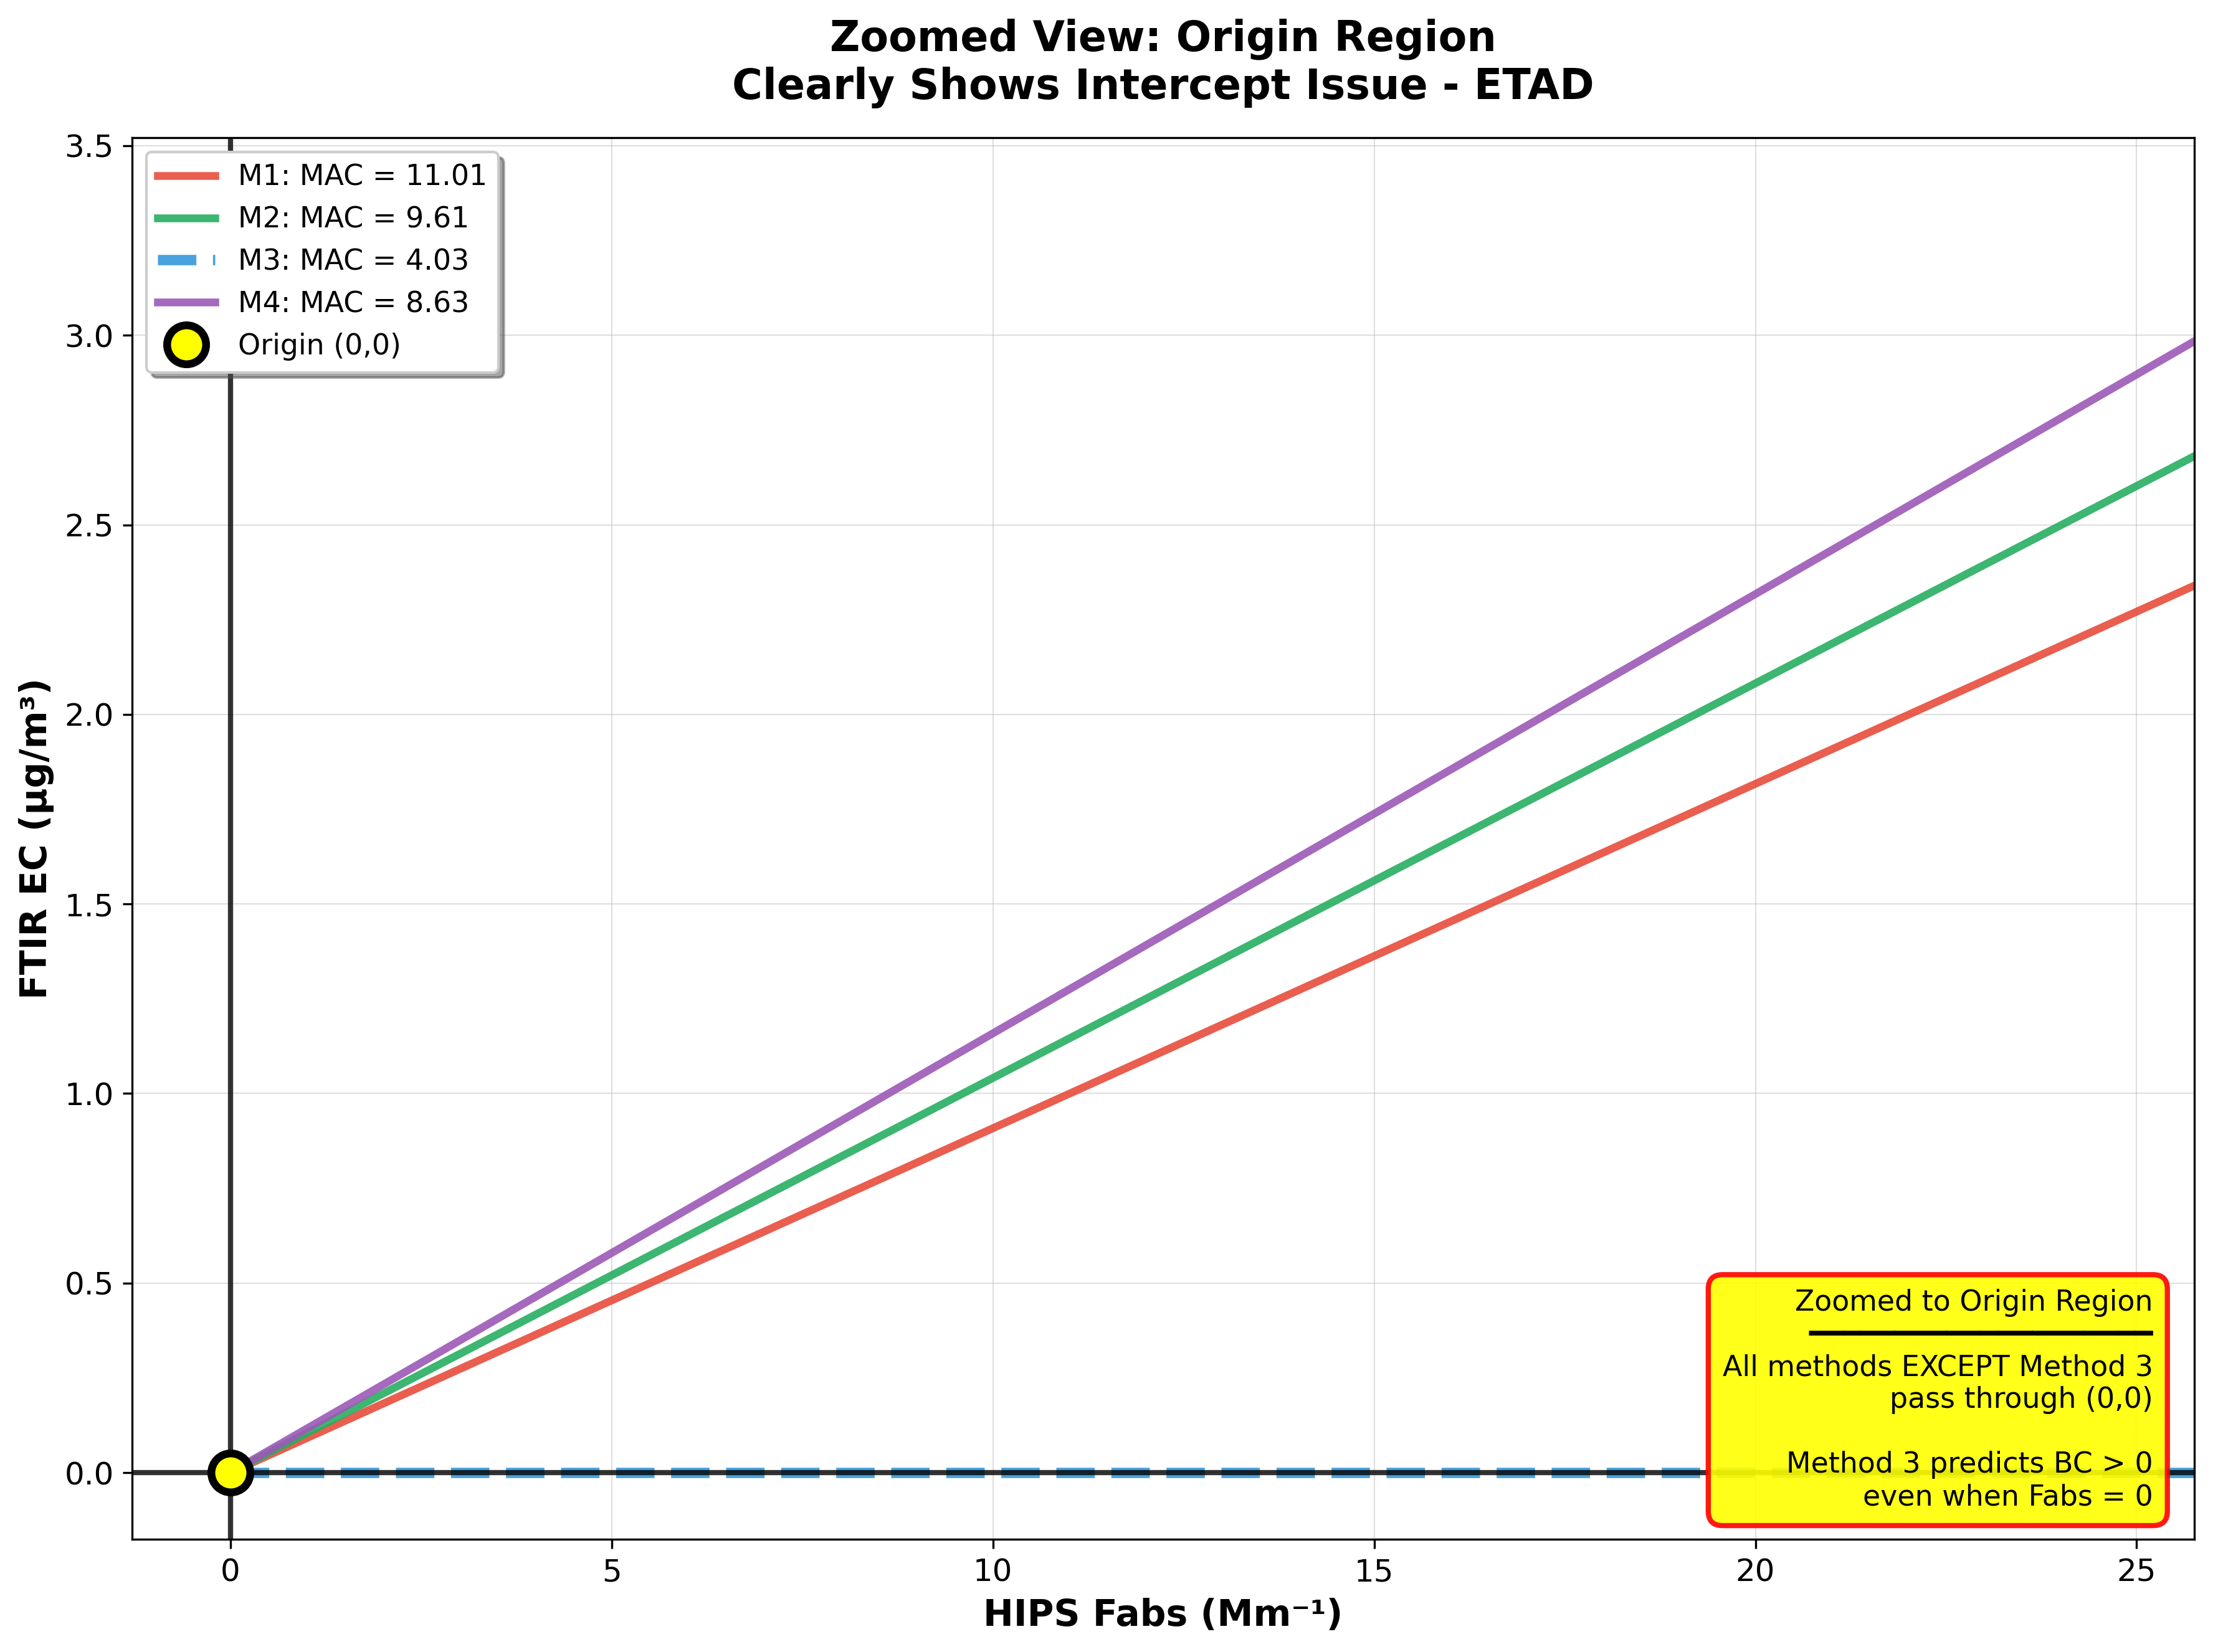

In [8]:

# %%
def plot_origin_zoom(results, site_code='ETAD'):
    """
    Create a zoomed-in plot focusing on the origin region
    to clearly show the intercept issue
    """
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Extract data
    fabs_range = results['fabs_range']
    
    # Set zoom limits - focus on low Fabs values
    fabs_max = max(results['fabs_original']) * 0.3  # Show first 30% of data range
    ec_max = max(results['ec_original']) * 0.3
    
    # Plot only the low range
    fabs_zoom = np.linspace(0, fabs_max, 100)
    
    # Plot BC equivalent lines
    for i, (method_name, data) in enumerate(results['methods'].items(), 1):
        method_short = f"M{i}"
        
        # Calculate BC for zoomed range
        if data['intercept'] != 0:
            bc_zoom = np.maximum(fabs_zoom - data['intercept'], 0) / data['mac']
            linestyle = '--'
            linewidth = 4
        else:
            bc_zoom = fabs_zoom / data['mac']
            linestyle = '-'
            linewidth = 3
        
        ax.plot(fabs_zoom, bc_zoom, 
               color=data['color'], linewidth=linewidth, linestyle=linestyle,
               alpha=0.9, label=f"{method_short}: MAC = {data['mac']:.2f}")
    
    # Highlight the origin
    ax.plot(0, 0, 'ko', markersize=15, markeredgewidth=3, 
            markerfacecolor='yellow', label='Origin (0,0)', zorder=10)
    
    # Add grid at origin
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=2)
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.8, linewidth=2)
    
    # Annotate Method 3's intercept
    for method_name, data in results['methods'].items():
        if data['intercept'] > 0 and data['intercept'] < fabs_max:
            ax.axvline(x=data['intercept'], color=data['color'], 
                      linestyle=':', alpha=0.7, linewidth=3)
            ax.text(data['intercept'], ec_max * 0.5, 
                   f"Method 3\nBaseline\n{data['intercept']:.1f} Mm⁻¹", 
                   ha='center', color=data['color'], fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))
            
            # Show the BC value at Fabs=0
            bc_at_zero = data['bc_at_zero_fabs']
            ax.plot(0, bc_at_zero, 'X', color='red', markersize=15, 
                   markeredgewidth=2, label=f'M3 at Fabs=0: BC={bc_at_zero:.2f}')
    
    ax.set_xlabel('HIPS Fabs (Mm⁻¹)', fontweight='bold', fontsize=14)
    ax.set_ylabel('FTIR EC (μg/m³)', fontweight='bold', fontsize=14)
    ax.set_title(f'Zoomed View: Origin Region\n'
                f'Clearly Shows Intercept Issue - {site_code}', 
                fontweight='bold', fontsize=16, pad=15)
    
    ax.set_xlim(-fabs_max*0.05, fabs_max)
    ax.set_ylim(-ec_max*0.05, ec_max)
    
    ax.legend(loc='upper left', frameon=True, fancybox=True, 
             shadow=True, fontsize=11)
    ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.5)
    
    # Add explanation
    explanation = (
        "Zoomed to Origin Region\n"
        "━━━━━━━━━━━━━━━━━━━━\n"
        "All methods EXCEPT Method 3\n"
        "pass through (0,0)\n\n"
        "Method 3 predicts BC > 0\n"
        "even when Fabs = 0"
    )
    
    ax.text(0.98, 0.02, explanation, transform=ax.transAxes, fontsize=11,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', 
                     alpha=0.9, edgecolor='red', linewidth=2))
    
    plt.tight_layout()
    
    return fig

# Create the zoomed plot
fig_zoom = plot_origin_zoom(results, site_code=SITE_CODE)
plt.show()

In [9]:
def print_summary_table(results):
    """
    Print a formatted summary table of all methods
    """
    
    print(f"\n{'='*100}")
    print(f"PHYSICAL CONSTRAINT ANALYSIS SUMMARY")
    print(f"{'='*100}\n")
    
    print(f"{'Method':<30} {'MAC (m²/g)':<12} {'Intercept':<12} {'BC@Fabs=0':<12} {'Constraint':<15}")
    print(f"{'-'*100}")
    
    for i, (method_name, data) in enumerate(results['methods'].items(), 1):
        mac = data['mac']
        intercept = data['intercept']
        bc_at_zero = data['bc_at_zero_fabs']
        
        # Check if constraint is satisfied
        if abs(bc_at_zero) < 0.01:
            constraint = "✅ SATISFIED"
        else:
            constraint = "⚠️  VIOLATED"
        
        print(f"{method_name:<30} {mac:<12.3f} {intercept:<12.3f} {bc_at_zero:<12.3f} {constraint:<15}")
    
    print(f"\n{'='*100}")
    print(f"INTERPRETATION GUIDE")
    print(f"{'='*100}\n")
    
    print("✅ SATISFIED = Method predicts BC = 0 when Fabs = 0")
    print("   • Assumes all absorption is from BC")
    print("   • No baseline absorption component")
    print("   • Mathematically passes through origin\n")
    
    print("⚠️  VIOLATED = Method predicts BC ≠ 0 when Fabs = 0")
    print("   • Has non-zero intercept/baseline")
    print("   • Could represent:")
    print("     - Real non-BC absorption (brown carbon, dust)")
    print("     - Instrument baseline/artifact")
    print("     - Regression artifact from data distribution\n")
    
    print(f"{'='*100}")
    print(f"DECISION FRAMEWORK")
    print(f"{'='*100}\n")
    
    print("IF you believe all absorption is from BC")
    print("  → Use Method 1, 2, or 4 (satisfy constraint)\n")
    
    print("IF you believe there is real baseline absorption")
    print("  → Method 3 might be correct (intercept = baseline)\n")
    
    print("TO DECIDE:")
    print("  1. Check if blank filters show Fabs = 0")
    print("  2. Consider site characteristics (dust, brown carbon)")
    print("  3. Review independent measurements")
    print("  4. Assess instrument baseline stability")

# Print the summary
print_summary_table(results)

# %% [markdown]
# ## Optional: Save the Figures

# %%
# Uncomment to save the figures
# output_filename = f'physical_constraint_check_{SITE_CODE}.png'
# fig.savefig(output_filename, dpi=300, bbox_inches='tight')
# print(f"Figure saved to: {output_filename}")

# output_filename_zoom = f'physical_constraint_zoom_{SITE_CODE}.png'
# fig_zoom.savefig(output_filename_zoom, dpi=300, bbox_inches='tight')
# print(f"Zoomed figure saved to: {output_filename_zoom}")

print("\n" + "="*80)
print("NOTEBOOK COMPLETE!")
print("="*80)
print(f"\nAnalysis complete for {SITE_CODE}")
print(f"Total samples analyzed: {len(df)}")


PHYSICAL CONSTRAINT ANALYSIS SUMMARY

Method                         MAC (m²/g)   Intercept    BC@Fabs=0    Constraint     
----------------------------------------------------------------------------------------------------
Method 1: Mean of Ratios       11.008       0.000        0.000        ✅ SATISFIED    
Method 2: Ratio of Means       9.606        0.000        0.000        ✅ SATISFIED    
Method 3: Standard Regression  4.025        28.538       -7.090       ⚠️  VIOLATED   
Method 4: Origin Regression    8.631        0.000        0.000        ✅ SATISFIED    

INTERPRETATION GUIDE

✅ SATISFIED = Method predicts BC = 0 when Fabs = 0
   • Assumes all absorption is from BC
   • No baseline absorption component
   • Mathematically passes through origin

⚠️  VIOLATED = Method predicts BC ≠ 0 when Fabs = 0
   • Has non-zero intercept/baseline
   • Could represent:
     - Real non-BC absorption (brown carbon, dust)
     - Instrument baseline/artifact
     - Regression artifact from data d